# Build Visualization

In [1]:
import os
import glob

import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splev
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
from sunpy.map import Map,CompositeMap,GenericMap
import sunpy.cm
from astropy.coordinates import SkyCoord
import yt

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.maps import make_emission_measure_map

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def aiaprep(aiamap):
    # Target scale is 0.6 arcsec/pixel, but this needs to be adjusted if the map
    # has already been rescaled.
    if (aiamap.scale[0] / 0.6).round() != 1.0 * u.arcsec and aiamap.data.shape != (4096, 4096):
        scale = (aiamap.scale[0] / 0.6).round() * 0.6 * u.arcsec
    else:
        scale = 0.6 * u.arcsec  # pragma: no cover # can't test this because it needs a full res image
    scale_factor = aiamap.scale[0] / scale

    tempmap = aiamap.rotate(recenter=True, scale=scale_factor.value, missing=aiamap.min())

    # extract center from padded aiamap.rotate output
    # crpix1 and crpix2 will be equal (recenter=True), as aiaprep does not work with submaps
    center = np.floor(tempmap.meta['crpix1'])
    range_side = (center + np.array([-1, 1]) * aiamap.data.shape[0] / 2) * u.pix
    newmap = tempmap.submap(u.Quantity([range_side[0], range_side[0]]),
                            u.Quantity([range_side[1], range_side[1]]))

    newmap.meta['r_sun'] = newmap.meta['rsun_obs'] / newmap.meta['cdelt1']
    newmap.meta['lvl_num'] = 1.5

    return newmap

In [8]:
field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/nsci_image_contest/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:190: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:191: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:198: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self

Collect simulated maps. Prep them and mask them appropriately.

In [ ]:
aia = InstrumentSDOAIA([0,5000]*u.s)
aia.counts_file = '/storage-home/w/wtb2/data/nsci_image_contest/SDO_AIA_counts.h5'
aia.make_detector_array(field)

In [ ]:
temperature = np.logspace(4,9,500)*u.K
plt.figure(figsize=(10,10))
for chan in aia.channels:
    resp = splev(temperature.value,chan['temperature_response_spline'])
    plt.plot(temperature,resp/resp.max(),label=chan['name'])
plt.xscale('log')
#plt.yscale('log')
#plt.ylim([1e-30,1e-23])
plt.xlim([1e5,1e8])
plt.legend()

In [3]:
aia_maps = glob.glob('/storage-home/w/wtb2/data/nsci_image_contest/SDO_AIA/*/*.fits')

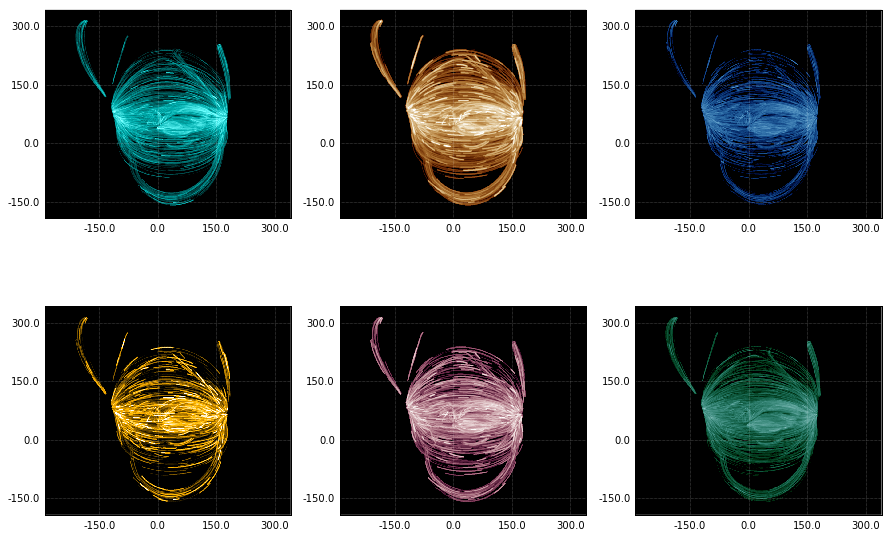

In [4]:
fig = plt.figure(figsize=(15,10))
for i,af in enumerate(aia_maps):
    m = Map(af)
    #bottom_left = SkyCoord(*lc,frame=m.coordinate_frame)
    #top_right = SkyCoord(*rc,frame=m.coordinate_frame)
    #m = m.submap(bottom_left,top_right)
    ax = fig.add_subplot(2,3,i+1,projection=m)
    m.plot(axes=ax,annotate=False,title=False,
           norm=matplotlib.colors.SymLogNorm(1e-2,vmin=1,vmax=1e3))

In [5]:
lc=(-200*u.arcsec,-50*u.arcsec)
rc=(250*u.arcsec,175*u.arcsec)
map_list = []
levels = [30,75,8,60,80,5]
for i in [5,2,3,]:#4]:
    tmp = aiaprep(Map(aia_maps[i]))
    bottom_left = SkyCoord(*lc,frame=tmp.coordinate_frame)
    top_right = SkyCoord(*rc,frame=tmp.coordinate_frame)
    tmp = tmp.submap(bottom_left,top_right)
    tmp = Map(np.ma.masked_less_equal(tmp.data,levels[i]),tmp.meta)
    map_list.append(tmp)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1282: Warning: GenericMap.submap now takes pixel values as `bottom_left` and `top_right` not `range_a` and `range_b`
  " and `top_right` not `range_a` and `range_b`", Warning)


Now crop the full-resolution HMI map to the same bounding box as the simulated map.

In [10]:
hmi_map = Map('/storage-home/w/wtb2/sunpy/data/hmi_m_45s_2017_08_20_18_16_30_tai_magnetogram.fits').rotate()
hmi_map = aiaprep(hmi_map)
hmi_map = hmi_map.submap(map_list[0].bottom_left_coord,map_list[0].top_right_coord)
hmi_map = Map(np.ma.masked_where(np.fabs(hmi_map.data)<50,hmi_map.data),hmi_map.meta)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1282: Warning: GenericMap.submap now takes pixel values as `bottom_left` and `top_right` not `range_a` and `range_b`
  " and `top_right` not `range_a` and `range_b`", Warning)


In [ ]:
hmi_map.peek()

In [ ]:
phot_map = Map('/storage-home/w/wtb2/sunpy/data/aia_lev1_1600a_2017_08_20t18_15_02_13z_image_lev1.fits')
phot_map = aiaprep(phot_map)
phot_map = phot_map.submap(map_list[0].bottom_left_coord,map_list[0].top_right_coord)

In [ ]:
phot_map.peek(vmin=50,vmax=1000)

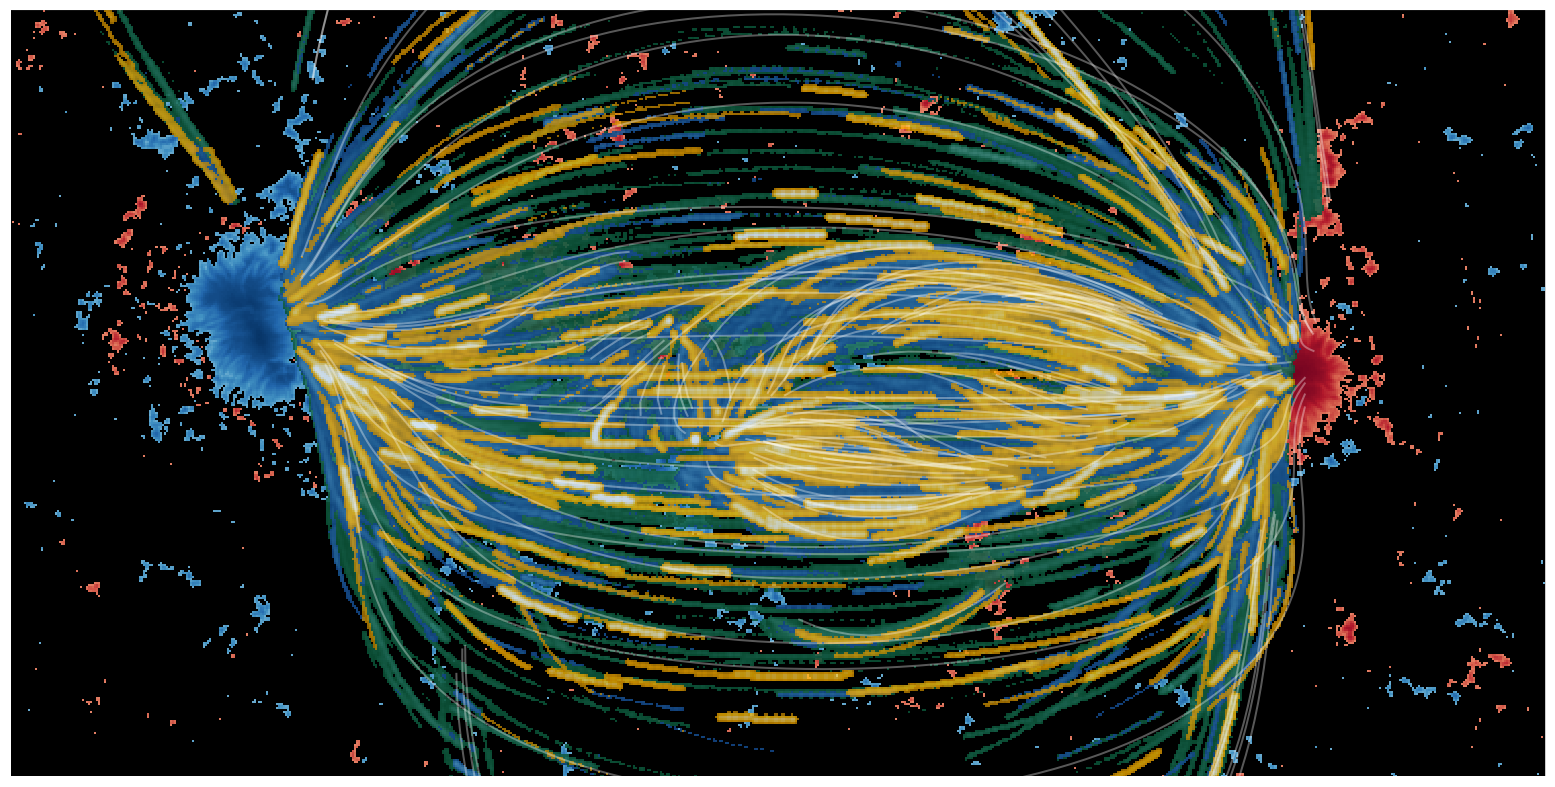

In [12]:
wh_ratio = 11/8
fig = plt.figure(figsize=(wh_ratio*20,20))
ax = fig.add_subplot(111,projection=hmi_map)
norm = matplotlib.colors.LogNorm(vmin=1,vmax=2.5e3)
hmi_cmap = plt.get_cmap('RdBu')
hmi_cmap.set_bad()
alphas = [0.9,0.9,0.75,0.05]
hmi_map.plot(axes=ax,
            norm=matplotlib.colors.SymLogNorm(5,vmin=-2500,vmax=2500),
            title=False,
            annotate=False,
            cmap=hmi_cmap
            )
#phot_map.plot(axes=ax,
#            #norm=matplotlib.colors.SymLogNorm(50,vmin=-1000,vmax=1000),
#            vmin=50,vmax=5e2,
#            title=False,
#            annotate=False,
#            #cmap=plt.get_cmap('RdGy')
#            )
for stream, _ in field.streamlines[::100]:
    x = field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg)
    y = field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg)
    ax.plot(x,y,alpha=0.35,color='w',transform=ax.get_transform('world'),lw=2)
for m,alpha in zip(map_list,alphas):
    im = m.plot(axes=ax,norm=norm,annotate=False,title=False)
    im.set_alpha(alpha)
b0 = hmi_map.world_to_pixel(hmi_map.bottom_left_coord)
b1 = hmi_map.world_to_pixel(hmi_map.top_right_coord)
ax.set_xlim([int(b0.x.value),int(b1.x.value)])
ax.set_ylim([int(b0.y.value),int(b1.y.value)])
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_ticklabel_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
lon.frame.set_linewidth(0)
lat.frame.set_linewidth(0)
lon.grid(draw_grid=False)
lat.grid(draw_grid=False)
fig.savefig('noaa12671_hmi_plus_aia.jpeg',format='jpeg',dpi=500,bbox_inches='tight')

### Title: Simulating Million-degree Plasma in the Solar Corona

### Description
Now provide a 100 word description of this image:

During the Great American Eclipse this past summer, millions of people across the United States watched as the moon moved in between the Sun and the Earth, providing a glimpse of the Sun's outer atmosphere, the corona. What those onlookers did not see was the active region (designated NOAA 12671) located nearly right at the center of the solar disk. Active regions are areas of intense magnetic activity on the solar surface and are often associated with sunspots (which can occassionally be observed with the naked eye). Plasma in the corona is trapped along magnetic fieldlines and can be heated to millions of degrees while the surface of the Sun remains at only a few thousand degrees. One explanation for the heating of the coronal plasma is nanoflares, wherein the magnetic field becomes tangled and twisted, resulting in many small bursts of magnetic energy.

This image visualizes a solar active region (AR), an area of intense magnetic activity on the Sun, where plasma in the corona, the outermost layer of the Sun's atmosphere, is heated to million-degree temperatures. This AR in particular was near the center of the Sun during the Great American Eclipse. Red (negative) and blue (positive) patches show the observed magnetic field strength and the faint white lines represent an approximation of the 3D magnetic field. The overlaid golden, blue, and green images show simulated intensity from coronal plasma heated by many small bursts of magnetic energy called nanoflares. Models like these help solar physicists understand the complex processes that heat the corona.


## Emission Measure Distribution Figure

In [ ]:
emcube = None
for t in aia.observing_time[10:110]:
    if emcube is None:
        emcube = make_emission_measure_map(t,field,aia,temperature_bin_edges=np.logspace(5,8,13)*u.K)
    else:
        emcube += make_emission_measure_map(t,field,aia,temperature_bin_edges=np.logspace(5,8,13)*u.K)

In [ ]:
fig = plt.figure(figsize=(8*2,6.75*2))
plt.subplots_adjust(wspace=0.,hspace=0.,top=0.95,right=0.945)
cax = fig.add_axes([0.95,0.13,0.02,0.815])
for i,emap in enumerate(emcube):
    ax = fig.add_subplot(4,3,i+1,projection=emap)
    tmp = GenericMap(gaussian_filter(emap.data,(5,5),),
                     emap.meta,plot_settings=emap.plot_settings)
    tmp.meta['detector'] = ''
    im = emap.plot(annotate=False,
                   title=False,
                   norm=matplotlib.colors.SymLogNorm(10,vmin=1e25,vmax=1e29),
                   cmap=plt.get_cmap('magma')
                  )
    if i%3 == 0:
        ax.set_ylabel('solar-y [arcsec]')
    else:
        ax.coords[1].set_ticklabel_visible(False)
    if i>5:
        ax.set_xlabel('solar-y [arcsec]')
    else:
        ax.coords[0].set_ticklabel_visible(False)
    #xtext,ytext = emap.data_to_pixel(-340*u.arcsec,-340*u.arcsec)
    #ax.text(xtext.value,ytext.value,
    #        r'{:.2f}-{:.2f} MK'.format(emap.meta['temp_a']/1e6,emap.meta['temp_b']/1e6),
    #        color='w',fontsize=14
    #       )
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)
#fig.suptitle(r'$t={}$ s'.format(1000),fontsize=18)
fig.colorbar(im,cax=cax)

In [ ]:
emcube[0].meta

## Cooling Only Models
Superimpose some cooling maps together.

In [ ]:
aia_cooling_maps = glob.glob('/storage-home/w/wtb2/data/noaa1158_cooling_model/SDO_AIA/*/map_t000300.fits')

In [ ]:
aia_cooling_maps

In [ ]:
lc=(-360*u.arcsec,-300*u.arcsec)
rc=(-180*u.arcsec,-150*u.arcsec)
cooling_map_list = []
levels = [30,75,8,60,80,1]
for i,am in enumerate(aia_cooling_maps):
    tmp = aiaprep(Map(am))
    bottom_left = SkyCoord(*lc,frame=tmp.coordinate_frame)
    top_right = SkyCoord(*rc,frame=tmp.coordinate_frame)
    tmp = tmp.submap(bottom_left,top_right)
    cooling_map_list.append(Map(np.ma.masked_less_equal(tmp.data,levels[i]),tmp.meta))

In [ ]:
hmi_cooling_map = Map('/storage-home/w/wtb2/sunpy/data/hmi_m_45s_2011_02_12_15_32_15_tai_magnetogram.fits').rotate()
hmi_cooling_map = aiaprep(hmi_cooling_map)
hmi_cooling_map = hmi_cooling_map.submap(cooling_map_list[0].bottom_left_coord,
                                         cooling_map_list[0].top_right_coord)

In [ ]:
hmi_cooling_map.peek()

In [ ]:
aia_cooling_maps

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection=hmi_cooling_map)
## HMI ##
hmi_cmap = plt.get_cmap('RdBu')
hmi_cmap.set_bad()
hmi_cooling_map.plot(axes=ax,
                     norm=matplotlib.colors.SymLogNorm(5,vmin=-2500,vmax=2500),
                     title=False,
                     annotate=False,
                     cmap=hmi_cmap
                    )
## AIA ##
norm = matplotlib.colors.LogNorm(vmin=0.1,vmax=2.5e3)
alphas = [0.85,0.85,0.85,0.55,0.85,0.75,]
for i,m in enumerate(cooling_map_list):
    im = m.plot(annotate=False,title=False,norm=norm,axes=ax)
    im.set_alpha(0.65)#alphas[i])